In [74]:
import numpy as np
import cPickle
import os
import dataset
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

In [49]:
data_path = "cifar10"

In [67]:
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = 10

########################################################################
# Various constants used to allocate arrays of the correct size.

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

########################################################################
# Private functions for downloading, unpacking and loading data-files.


def _get_file_path(filename=""):
    """
    Return the full path of a data-file for the data-set.
    If filename=="" then return the directory of the files.
    """

    return os.path.join(data_path, "cifar-10-batches-py/", filename)


def _unpickle(filename):
    """
    Unpickle the given file and return the data.
    Note that the appropriate dir-name is prepended the filename.
    """

    # Create full path for the file.
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = cPickle.load(file)

    return data


def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls


########################################################################
# Public functions that you may call to download the data-set from
# the internet and load the data into memory.


def maybe_download_and_extract():
    """
    Download and extract the CIFAR-10 data-set if it doesn't already exist
    in data_path (set this variable first to the desired path).
    """

    download.maybe_download_and_extract(url=data_url, download_dir=data_path)


def load_class_names():
    """
    Load the names for the classes in the CIFAR-10 data-set.
    Returns a list with the names. Example: names[3] is the name
    associated with class-number 3.
    """

    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']
    
    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return raw


def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set.
    The data-set is split into 5 data-files which are merged here.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls, dataset.one_hot_encoded(class_numbers=cls, num_classes=num_classes)


def load_test_data():
    """
    Load all the test-data for the CIFAR-10 data-set.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    images, cls = _load_data(filename="test_batch")

    return images, cls, dataset.one_hot_encoded(class_numbers=cls, num_classes=num_classes)

In [64]:
class_names = load_class_names()
class_names

Loading data: cifar10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [65]:
images_train, cls_train, labels_train = load_training_data()

Loading data: cifar10/cifar-10-batches-py/data_batch_1
Loading data: cifar10/cifar-10-batches-py/data_batch_2
Loading data: cifar10/cifar-10-batches-py/data_batch_3
Loading data: cifar10/cifar-10-batches-py/data_batch_4
Loading data: cifar10/cifar-10-batches-py/data_batch_5


In [68]:
images_test, cls_test, labels_test = load_test_data()

Loading data: cifar10/cifar-10-batches-py/test_batch


In [69]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


In [70]:
img_size_cropped = 24

## Plotting images

In [75]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


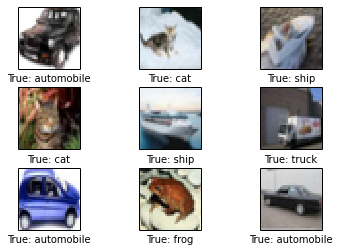

In [82]:
# Get the first images from the test-set.
rand = np.random.randint(0, 9000)
images = images_test[rand:rand+9]

# Get the true classes for those images.
cls_true = cls_test[rand:rand+9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

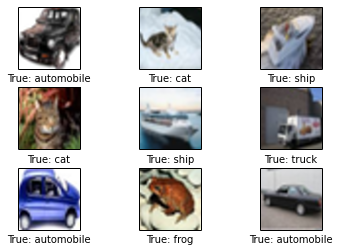

In [83]:
plot_images(images=images, cls_true=cls_true, smooth=True)

## TensorFlow Graph

### Placeholder variables

In [84]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

### Pre-Processing


In [85]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

In [86]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In [87]:
distorted_images = pre_process(images=x, training=True)

### Create the CNN

In [89]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    # It is very similar to the previous tutorials, except
    # the use of so-called batch-normalization in the first layer.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

    return y_pred, loss

In [90]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### Training Phase

In [93]:
global_step = tf.Variable(initial_value=0,
                          
                          name='global_step', trainable=False)
_, loss = create_network(training=True)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

### Test Phase

In [94]:
y_pred, _ = create_network(training=False)

y_pred_cls = tf.argmax(y_pred, dimension=1)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

In [139]:
saver = tf.train.Saver()

### Getting weights

In [95]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

In [96]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

### Getting the Layer Outputs

In [97]:
def get_layer_output(layer_name):
    # The name of the last operation of the convolutional layer.
    # This assumes you are using Relu as the activation-function.
    tensor_name = "network/" + layer_name + "/Relu:0"

    # Get the tensor with this name.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

In [98]:
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')

## Run TensorFlow Graph

In [174]:
session = tf.Session()

### Restore or initialize variables

In [175]:
save_dir = 'checkpoints/'

In [176]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [177]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

In [178]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
('Restored checkpoint from:', u'checkpoints/cifar10_cnn-0')


### Training batch

In [179]:
train_batch_size = 64

In [180]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

###  Optimization

In [181]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
            
#             print_test_accuracy(show_example_errors=False,
#                     show_confusion_matrix=False)

        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")
    
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [182]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])


In [183]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

In [184]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [185]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

In [186]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

In [187]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

#     # Plot the confusion matrix, if desired.
#     if show_confusion_matrix:
#         print("Confusion Matrix:")
#         plot_confusion_matrix(cls_pred=cls_pred)

### Distorted input images

In [188]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # Create a feed-dict for TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calculate only the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = session.run(distorted_images, feed_dict=feed_dict)

    # Plot the images.
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

In [189]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

In [190]:
img, cls = get_test_image(1000)

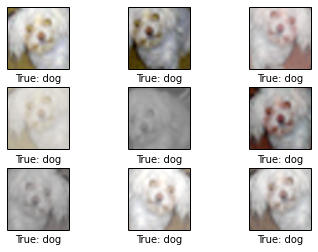

In [191]:
plot_distorted_image(img, cls)

### Perform training 

In [192]:
optimize(num_iterations=1000)

Global Step:      0, Training Batch Accuracy:  50.0%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  35.9%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  46.9%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  35.9%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  43.8%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  53.1%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  46.9%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  46.9%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  50.0%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  54.7%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  40.6%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  42.2%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  43.8%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  43.8%
Saved checkpoint.
Global

KeyboardInterrupt: 

In [194]:
# print_test_accuracy(show_example_errors=True,
#                     show_confusion_matrix=False)

## Reference

1. Convolutional Neural Networks Tutorial by Google Tensorflow
   https://www.tensorflow.org/tutorials/deep_cnn
2. Image augmentation https://github.com/aleju/imgaug

3. TensorFlow Tutorial by Magnus Erik Hvass Pedersen
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb

License (MIT)
Copyright (c) 2016 by Magnus Erik Hvass Pedersen
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.